# Plot histograms

N.B. Data should be placed in `/brainlit/data/poster/reproduction`

In [1]:
import numpy as np
import brainlit
import scipy
from brainlit.utils import swc
from cloudvolume.exceptions import SkeletonDecodeError
from brainlit.algorithms.trace_analysis.fit_spline import GeometricGraph
from brainlit.algorithms.trace_analysis.spline_fxns import curvature, torsion
import os
from pathlib import Path
import pandas as pd
from networkx.readwrite import json_graph
import json
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import torch

/cis/home/jteneggi/anaconda3/envs/cuda10/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


## Define brain, find trace data folder

In [2]:
brain = "brain1"
root_dir = data_dir = Path(os.path.abspath('')).parents[1]
data_dir = os.path.join(root_dir, "data/poster_reproduction/{}".format(brain))
experiment_dir = os.path.join(root_dir, "experiments/poster_reproduction")
segments_dir = os.path.join(data_dir, "segments")
segments_swc_dir = os.path.join(data_dir, "segments_swc")
trace_data_dir = os.path.join(data_dir, "trace_data")
print(segments_dir)

/cis/home/jteneggi/repo/brainlit/data/poster_reproduction/brain1/segments


## Read trace data

In [3]:
max_id = 300
seg_lengths = []
mean_torsions = []
mean_curvatures = []
d_from_root = []
torsions = []
curvatures = []
for i in np.arange(0, max_id):
    i = int(i)
    trace_data_path = os.path.join(trace_data_dir, "{}.npy".format(i))
    if os.path.exists(trace_data_path) is True:
        trace_data = np.load(trace_data_path, allow_pickle=True)
        print("Loaded segment {}".format(i))

        for node in trace_data:
            # print(node)
            seg_lengths.append(node["seg_length"])
            mean_curvatures.append(node["mean_curvature"])
            mean_torsions.append(node["mean_torsion"])
            
# ARRAY MANIPULATION TO CONVERT EVERYTHING TO NUMPY, REMOVE POINTS THAT WOULD YIELD -INF IN LOG
seg_lengths = np.array(seg_lengths)
mean_curvatures = np.array(mean_curvatures)
mean_torsions = np.abs(np.array(mean_torsions))

Loaded segment 2
Loaded segment 7
Loaded segment 11
Loaded segment 12
Loaded segment 13
Loaded segment 14
Loaded segment 20
Loaded segment 24
Loaded segment 28
Loaded segment 35
Loaded segment 40
Loaded segment 45
Loaded segment 48
Loaded segment 49
Loaded segment 51
Loaded segment 53
Loaded segment 59
Loaded segment 60
Loaded segment 65
Loaded segment 67
Loaded segment 69
Loaded segment 71
Loaded segment 72
Loaded segment 73
Loaded segment 74
Loaded segment 75
Loaded segment 76
Loaded segment 77
Loaded segment 78
Loaded segment 79
Loaded segment 81
Loaded segment 82
Loaded segment 83
Loaded segment 85
Loaded segment 86
Loaded segment 91
Loaded segment 97
Loaded segment 98
Loaded segment 99
Loaded segment 101
Loaded segment 103
Loaded segment 106
Loaded segment 107
Loaded segment 109
Loaded segment 111
Loaded segment 112
Loaded segment 115
Loaded segment 118
Loaded segment 120
Loaded segment 124
Loaded segment 126
Loaded segment 127
Loaded segment 129
Loaded segment 132
Loaded segment 

# Define helper variables

In [4]:
log_seg_lengths = np.log10(seg_lengths)
min_log_seg_length = min(log_seg_lengths)
max_log_seg_length = max(log_seg_lengths)
xx = np.linspace(min_log_seg_length, max_log_seg_length, 1000)[:, np.newaxis]

## Compute KDE of the curvatures

In [5]:
zero_curvatures_log_seg_lengths = log_seg_lengths[np.where(mean_curvatures < 1e-16)[0]]
nonzero_curvatures_log_seg_lengths = log_seg_lengths[
    np.where(mean_curvatures > 1e-16)[0]
]
zero_kde = KernelDensity(kernel="gaussian", bandwidth=0.1).fit(
    zero_curvatures_log_seg_lengths[:, np.newaxis]
)
nonzero_kde = KernelDensity(kernel="gaussian", bandwidth=0.25).fit(
    nonzero_curvatures_log_seg_lengths[:, np.newaxis]
)
zero_log_dens = zero_kde.score_samples(xx)
nonzero_log_dens = nonzero_kde.score_samples(xx)
# ax.hist(zero_curvatures_log_seg_lengths, density=True)
# ax.hist(nonzero_curvatures_log_seg_lengths, density=True)
alpha_zero_curvatures = len(zero_curvatures_log_seg_lengths) / len(seg_lengths)
alpha_nonzero_curvatures = len(nonzero_curvatures_log_seg_lengths) / len(seg_lengths)
print(alpha_zero_curvatures, alpha_nonzero_curvatures)
zero_curvatures_norm_pdf = alpha_zero_curvatures * np.exp(zero_log_dens)
nonzero_curvatures_norm_pdf = alpha_nonzero_curvatures * np.exp(nonzero_log_dens)

0.24138821273143027 0.7586117872685697


## Compute KDE of the torsions

In [6]:
zero_torsions_log_seg_lengths = log_seg_lengths[np.where(mean_torsions < 1e-16)[0]]
nonzero_torsions_log_seg_lengths = log_seg_lengths[np.where(mean_torsions > 1e-16)[0]]
zero_kde = KernelDensity(kernel="gaussian", bandwidth=0.1).fit(
    zero_torsions_log_seg_lengths[:, np.newaxis]
)
nonzero_kde = KernelDensity(kernel="gaussian", bandwidth=0.25).fit(
    nonzero_torsions_log_seg_lengths[:, np.newaxis]
)
zero_log_dens = zero_kde.score_samples(xx)
nonzero_log_dens = nonzero_kde.score_samples(xx)
# ax.hist(zero_torsions_log_seg_lengths, density=True)
# ax.hist(nonzero_torsions_log_seg_lengths, density=True)
alpha_zero_torsions = len(zero_torsions_log_seg_lengths) / len(seg_lengths)
alpha_nonzero_torsions = len(nonzero_torsions_log_seg_lengths) / len(seg_lengths)
print(alpha_zero_torsions, alpha_nonzero_torsions)
zero_torsions_norm_pdf = alpha_zero_torsions * np.exp(zero_log_dens)
nonzero_torsions_norm_pdf = alpha_nonzero_torsions * np.exp(nonzero_log_dens)

0.38658995352954195 0.613410046470458


## Plot figure

Text(0.5, 0.98, 'Brain 1')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


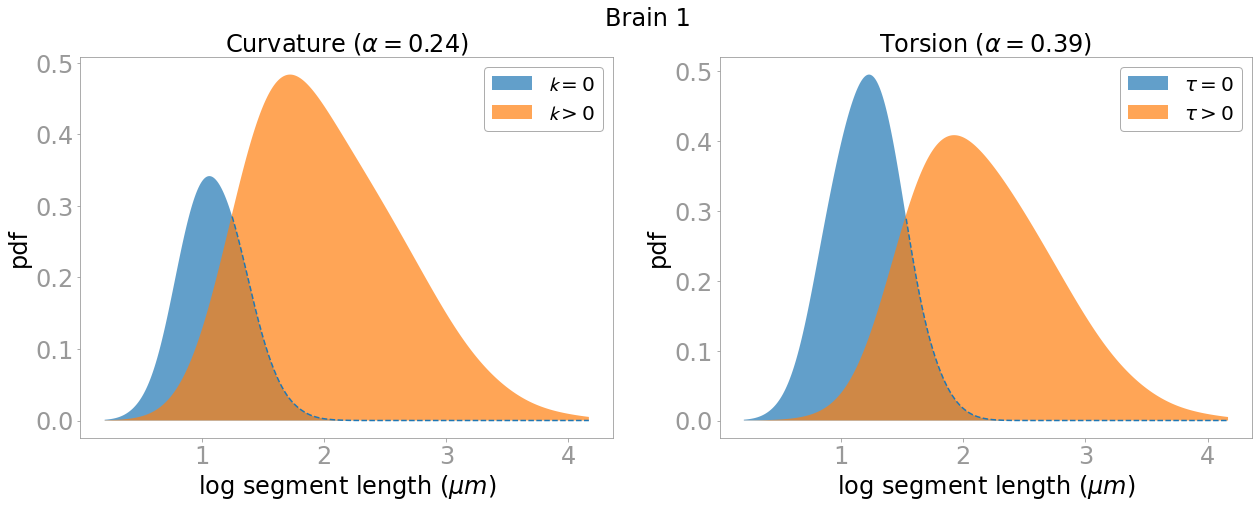

In [7]:
fig = plt.figure(figsize=(21, 7))
axes = fig.subplots(1, 2)
GRAY = "#999999"
TITLE_TYPE_SETTINGS = {"fontname": "Arial", "size": 20}
SUP_TITLE_TYPE_SETTINGS = {"fontname": "Arial", "size": 24}
plt.rc("font", family="Arial", size=20)

log_seg_lengths = np.log10(seg_lengths)
min_log_seg_length = min(log_seg_lengths)
max_log_seg_length = max(log_seg_lengths)
xx = np.linspace(min_log_seg_length, max_log_seg_length, 1000)[:, np.newaxis]

ax = axes[0]
ax.spines["bottom"].set_color(GRAY)
ax.spines["top"].set_color(GRAY)
ax.spines["right"].set_color(GRAY)
ax.spines["left"].set_color(GRAY)
ax.tick_params(axis="both", colors=GRAY, labelsize="large")

ax.fill_between(xx.squeeze(), 0, zero_curvatures_norm_pdf, alpha=0.7, label=r"$\mathcal{k} = 0$")
ax.fill_between(
    xx.squeeze(), 0, nonzero_curvatures_norm_pdf, alpha=0.7, label=r"$\mathcal{k} > 0$"
)

mask = np.array(
    [
        False if zero_ > nonzero_ else True
        for zero_, nonzero_ in zip(zero_curvatures_norm_pdf, nonzero_curvatures_norm_pdf)
    ]
)
ids = np.where(mask == True)[0]
xx_dashed = xx.squeeze()[ids]
zero_curvatures_norm_pdf_dashed = zero_curvatures_norm_pdf[ids]
ax.plot(xx_dashed.squeeze(), zero_curvatures_norm_pdf_dashed, "--")


ax.set_title(r"Curvature ($\alpha = %.2f$)" % alpha_zero_curvatures)
ax.set_xlabel(r"$\log$ segment length ($\mu m$)", fontsize=24)
ax.set_ylabel(r"pdf", fontsize=24)
leg = ax.legend(loc=1)
leg.get_frame().set_edgecolor(GRAY)
ax.set_xticks([1, 2, 3, 4])

ax = axes[1]
ax.spines["bottom"].set_color(GRAY)
ax.spines["top"].set_color(GRAY)
ax.spines["right"].set_color(GRAY)
ax.spines["left"].set_color(GRAY)
ax.tick_params(axis="both", colors=GRAY, labelsize="large")

ax.fill_between(xx.squeeze(), 0, zero_torsions_norm_pdf, alpha=0.7, label=r"$\tau = 0$")
ax.fill_between(xx.squeeze(), 0, nonzero_torsions_norm_pdf, alpha=0.7, label=r"$\tau > 0$")

mask = np.array(
    [
        False if zero_ > nonzero_ else True
        for zero_, nonzero_ in zip(zero_torsions_norm_pdf, nonzero_torsions_norm_pdf)
    ]
)
ids = np.where(mask == True)[0]
xx_dashed = xx.squeeze()[ids]
zero_torsions_norm_pdf_dashed = zero_torsions_norm_pdf[ids]
ax.plot(xx_dashed.squeeze(), zero_torsions_norm_pdf_dashed, "--")

ax.set_title(r"Torsion ($\alpha = %.2f$)" % alpha_zero_torsions)
ax.set_xlabel(r"$\log$ segment length ($\mu m$)", fontsize=24)
ax.set_ylabel(r"pdf", fontsize=24)
leg = ax.legend(loc=1)
leg.get_frame().set_edgecolor(GRAY)
ax.set_xticks([1, 2, 3, 4])

fig.suptitle("Brain 1")

## Save figure

In [8]:
plt.savefig(os.path.join(experiment_dir, "figures/{}_histograms.jpg".format(brain)))
plt.savefig(os.path.join(experiment_dir, "figures/{}_histograms.eps".format(brain)))

<Figure size 432x288 with 0 Axes>